# Image Classification Example:
Source: http://blog.yhathq.com/posts/image-classification-in-Python.html


In [2]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os
import base64
from StringIO import StringIO

In [3]:
from sklearn.decomposition import RandomizedPCA
from sklearn.neighbors import KNeighborsClassifier

In [4]:
%matplotlib inline

<h2>Importing Image Data</h2>

<h5>Create Processing Functions</h5>

In [5]:
#setup a standard image size; this will distort some images but will get everything into the same shape
STANDARD_SIZE = (230, 170)
def img_to_matrix(filename, verbose=False):
    """
    takes a filename and turns it into a numpy array of RGB pixels
    """
    img = PIL.Image.open(filename)
    if verbose==True:
        print "changing size from %s to %s" % (str(img.size), str(STANDARD_SIZE))
    img = img.resize(STANDARD_SIZE)
    img = list(img.getdata())
    img = map(list, img)
    img = np.array(img)
    return img

<h5>Define the location of your data and import it</h5>

In [18]:
# TODO PATH TO YOUR DATA
img_dir = "/home/rwdavis513/tutorials/imageClassification/images/"
imgCat = ['beach','mountain']
images = [img_dir+ f for f in os.listdir(img_dir)]
labels = [imgCat[0] if imgCat[0] in f.split('/')[-1] else imgCat[1] for f in images]

In [19]:
data = []
for image in images:
    img = img_to_matrix(image)
    #img = flatten_image(img)
    img = img.flatten('C')
    data.append(img)

data = np.array(data)
data

array([[252, 204, 200, ..., 221, 221, 221],
       [222, 222, 214, ..., 221, 221, 221],
       [196, 225, 243, ..., 218, 218, 216],
       ..., 
       [181, 233, 255, ..., 244, 221, 180],
       [209, 222, 238, ..., 228, 221, 215],
       [225, 220, 216, ..., 221, 221, 221]])

In [20]:
data.shape

(54, 117300)

<h2>Creating Features</h2>

<h5>Define a training and test set</h5>

In [21]:
is_train = np.random.uniform(0, 1, len(data)) <= 0.7
y = np.where(np.array(labels)==imgCat[0], 1, 0)

train_x, train_y = data[is_train], y[is_train]
test_x, test_y = data[is_train==False], y[is_train==False]

<h5>RandomizedPCA to create features</h5>
<p>Before we actually create our feature vectors, we're going to show a demo of <code>RandomizedPCA</code> in 2 dimensions. This makes it easy to plot high dimensional data</p>

In [22]:
pca = RandomizedPCA(n_components=2)
X = pca.fit_transform(data)
df = pd.DataFrame({"x": X[:, 0], "y": X[:, 1], "label":np.where(y==1, imgCat[0], imgCat[1])})

In [23]:
X

array([[-27098.37807709,  -3826.02516092],
       [ 20116.4909018 , -12770.80741281],
       [-14947.20588269,   7193.31285982],
       [ -8409.89302586,  -5641.00961258],
       [ -7655.18028938,    932.96113984],
       [ -9890.38330368,   3596.54402063],
       [ 16713.63158116,   4893.75159391],
       [-11956.45268722, -10542.21940539],
       [ -5526.1016472 ,   -582.49009333],
       [ -8033.31522644,  -9758.51265444],
       [-13139.59536209,  15687.06185178],
       [ -9321.88480798,    444.57163995],
       [-17444.32788834,   -793.24420745],
       [ 11340.65893749,  -1386.73631956],
       [ 13348.94745291,   6738.9383446 ],
       [ 11446.82433617,   4931.97463515],
       [ -6425.46485341, -12946.36033085],
       [  6800.21731627,  -6238.90327637],
       [  7535.68318669,  -2549.34078346],
       [-16455.22584512, -10177.51069308],
       [ 18799.72504723, -13482.6070283 ],
       [-20850.90006088,   2193.79957322],
       [  9975.88939808,  -7476.03186247],
       [ 22

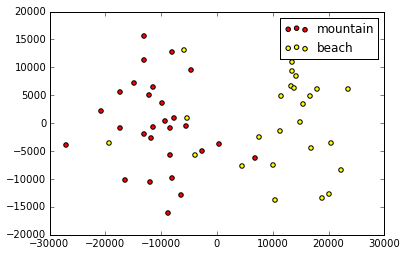

In [24]:
df.head()
colors = ["red", "yellow"]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=label)
plt.legend()

<h2>RandomizedPCA in 5 dimensions</h2>
<p>Instead of 2 dimenisons, we're going to do RandomizedPCA in 5 dimensions. This will make it a bit harder to visualize, but it will make it easier for some of the classifiers to work with the dataset.</p>

In [25]:
pca = RandomizedPCA(n_components=5)
train_x = pca.fit_transform(train_x)
test_x = pca.transform(test_x)

<p>This gives our classifier a nice set of tabular data that we can then use to train the model</p>

In [26]:
pca.explained_variance_ratio_

array([ 0.38591236,  0.12447478,  0.0773281 ,  0.04615667,  0.03974096])

<p>We're going to be using a <code>K-Nearest Neighbors</code> classifier. Based on our set of training data, we're going to caclulate which training obersvations are closest to a given test point. Whichever class has the most votes wins.</p>

In [27]:
knn = KNeighborsClassifier()
knn.fit(train_x, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

# Model Accuracy

<p>Now we'll see how accurate the model is on the training dataset and then the test dataset. </p>

In [53]:
pd.crosstab(train_y, knn.predict(train_x), rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,18,0
1,3,17


In [31]:
pred_y = knn.predict(test_x)
print(pred_y)
print(test_y)

[0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1]
[0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 1]


In [32]:
pd.crosstab(test_y, pred_y, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,9,1
1,2,4


In [49]:
listOfTestImages = [ x for (i,x) in enumerate(images) if is_train[i]==False]

In [51]:
for i,img in enumerate(listOfTestImages):
    if pred_y[i] != test_y[i]:
        print(img)

/home/rwdavis513/tutorials/imageClassification/images/mountain_13
/home/rwdavis513/tutorials/imageClassification/images/beach_26
/home/rwdavis513/tutorials/imageClassification/images/beach_1
